In [1]:
import torch
import pickle
from torch import nn, optim
from math import pi as PI
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.temporal import generator_2dspatial_rectangle, generator_2dspatial_segment, generator_temporal
from neurodiffeq.temporal import FirstOrderInitialCondition, BoundaryCondition
from neurodiffeq.temporal import SingleNetworkApproximator2DSpatialTemporal
from neurodiffeq.temporal import Monitor2DSpatialTemporal, MonitorMinimal
from neurodiffeq.temporal import _solve_2dspatial_temporal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib.tri as tri

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
# torch.set_default_tensor_type('torch.cuda.DoubleTensor')
# torch.backends.cudnn.benchmark = True

In [4]:
C = 2**0.5
M = 2.
N = 1.
L_X = 1.0
L_Y = 1.0

def drum(u, x, y, t):
    return diff(u, t, order=2) - C**2 * (diff(u, x, order=2) + diff(u, y, order=2))

def u0(x, y):
    # mode(1, 2) + mode(2, 1)
    return torch.sin(M*PI*x/L_X) * torch.sin(N*PI*y/L_Y) + torch.sin(N*PI*x/L_X) * torch.sin(M*PI*y/L_Y)
def freq():
    return C / 2 * ((M/L_X)**2 + (N/L_Y)**2)**0.5
def analytical_solution(x, y, t):
    f = freq()
    return u0(x, y) * torch.cos(2*PI*f*t)

T_MAX = 1. / freq()

metrics = {}
def rmse(uu, xx, yy, tt):
    error = uu - analytical_solution(xx, yy, tt)
    return torch.mean(error**2)**0.5
metrics['rmse'] = rmse

In [5]:
class DrumApproximator(SingleNetworkApproximator2DSpatialTemporal):
    def __call__(self, xx, yy, tt):
        xx = torch.unsqueeze(xx, dim=1)
        yy = torch.unsqueeze(yy, dim=1)
        tt = torch.unsqueeze(tt, dim=1)
        xyt = torch.cat((xx, yy, tt), dim=1)
        lim_one = (1 - torch.exp(-tt))**2
        # hard coded second order initial condition: dudt|_{t=0} = 0
        uu = xx*(1-xx)*yy*(1-yy)* lim_one * self.single_network(xyt) + (1 - lim_one) * self.u0(xx, yy)
        return torch.squeeze(uu)

In [6]:
 # the second order initial condition is hard coded in DrumApproximator so here's only the first order initial one
initial_condition = FirstOrderInitialCondition(u0=u0)

train_gen_spatial = generator_2dspatial_rectangle(
    size=(16, 16), x_min=0.0, x_max=L_X, y_min=0.0, y_max=L_Y
)
train_gen_temporal = generator_temporal(size=16, t_min=0.0, t_max=T_MAX)
valid_gen_spatial = generator_2dspatial_rectangle(
    size=(8, 8), x_min=0.0, x_max=L_X, y_min=0.0, y_max=L_Y, random=False
)
valid_gen_temporal = generator_temporal(size=8, t_min=0.0, t_max=T_MAX, random=False)
# monitor = Monitor2DSpatialTemporal(
#     check_on_x=torch.linspace(0.0, L_X, 32),
#     check_on_y=torch.linspace(0.0, L_Y, 32),
#     check_on_t=torch.linspace(0.0, T_MAX, 3),
#     check_every=100
# )

fcnn = FCNN(
        n_input_units=3,
        n_output_units=1,
        n_hidden_units=64,
        n_hidden_layers=3,
        actv=nn.Tanh
)

fcnn_approximator = DrumApproximator(
    single_network=fcnn,
    pde=drum,
    initial_condition=initial_condition,
    boundary_conditions=[]
)
adam = optim.Adam(fcnn_approximator.parameters(), lr=0.001)

In [7]:
# %matplotlib notebook
# drum_solution, _ = _solve_2dspatial_temporal(
#     train_generator_spatial=train_gen_spatial,
#     train_generator_temporal=train_gen_temporal,
#     valid_generator_spatial=valid_gen_spatial,
#     valid_generator_temporal=valid_gen_temporal,
#     approximator=fcnn_approximator,
#     optimizer=adam,
#     batch_size=1024,
#     max_epochs=50000,
#     shuffle=True,
#     metrics=metrics,
#     monitor=MonitorMinimal(check_every=10)
# )
# %matplotlib inline

In [8]:
# torch.save(drum_solution.single_network, 'drum_nn.pt')

In [9]:
drum_solution = fcnn_approximator
drum_solution.single_network = torch.load('drum_nn.pt', map_location=torch.device('cpu'))

/opt/anaconda3/envs/nde/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


<IPython.core.display.Javascript object>


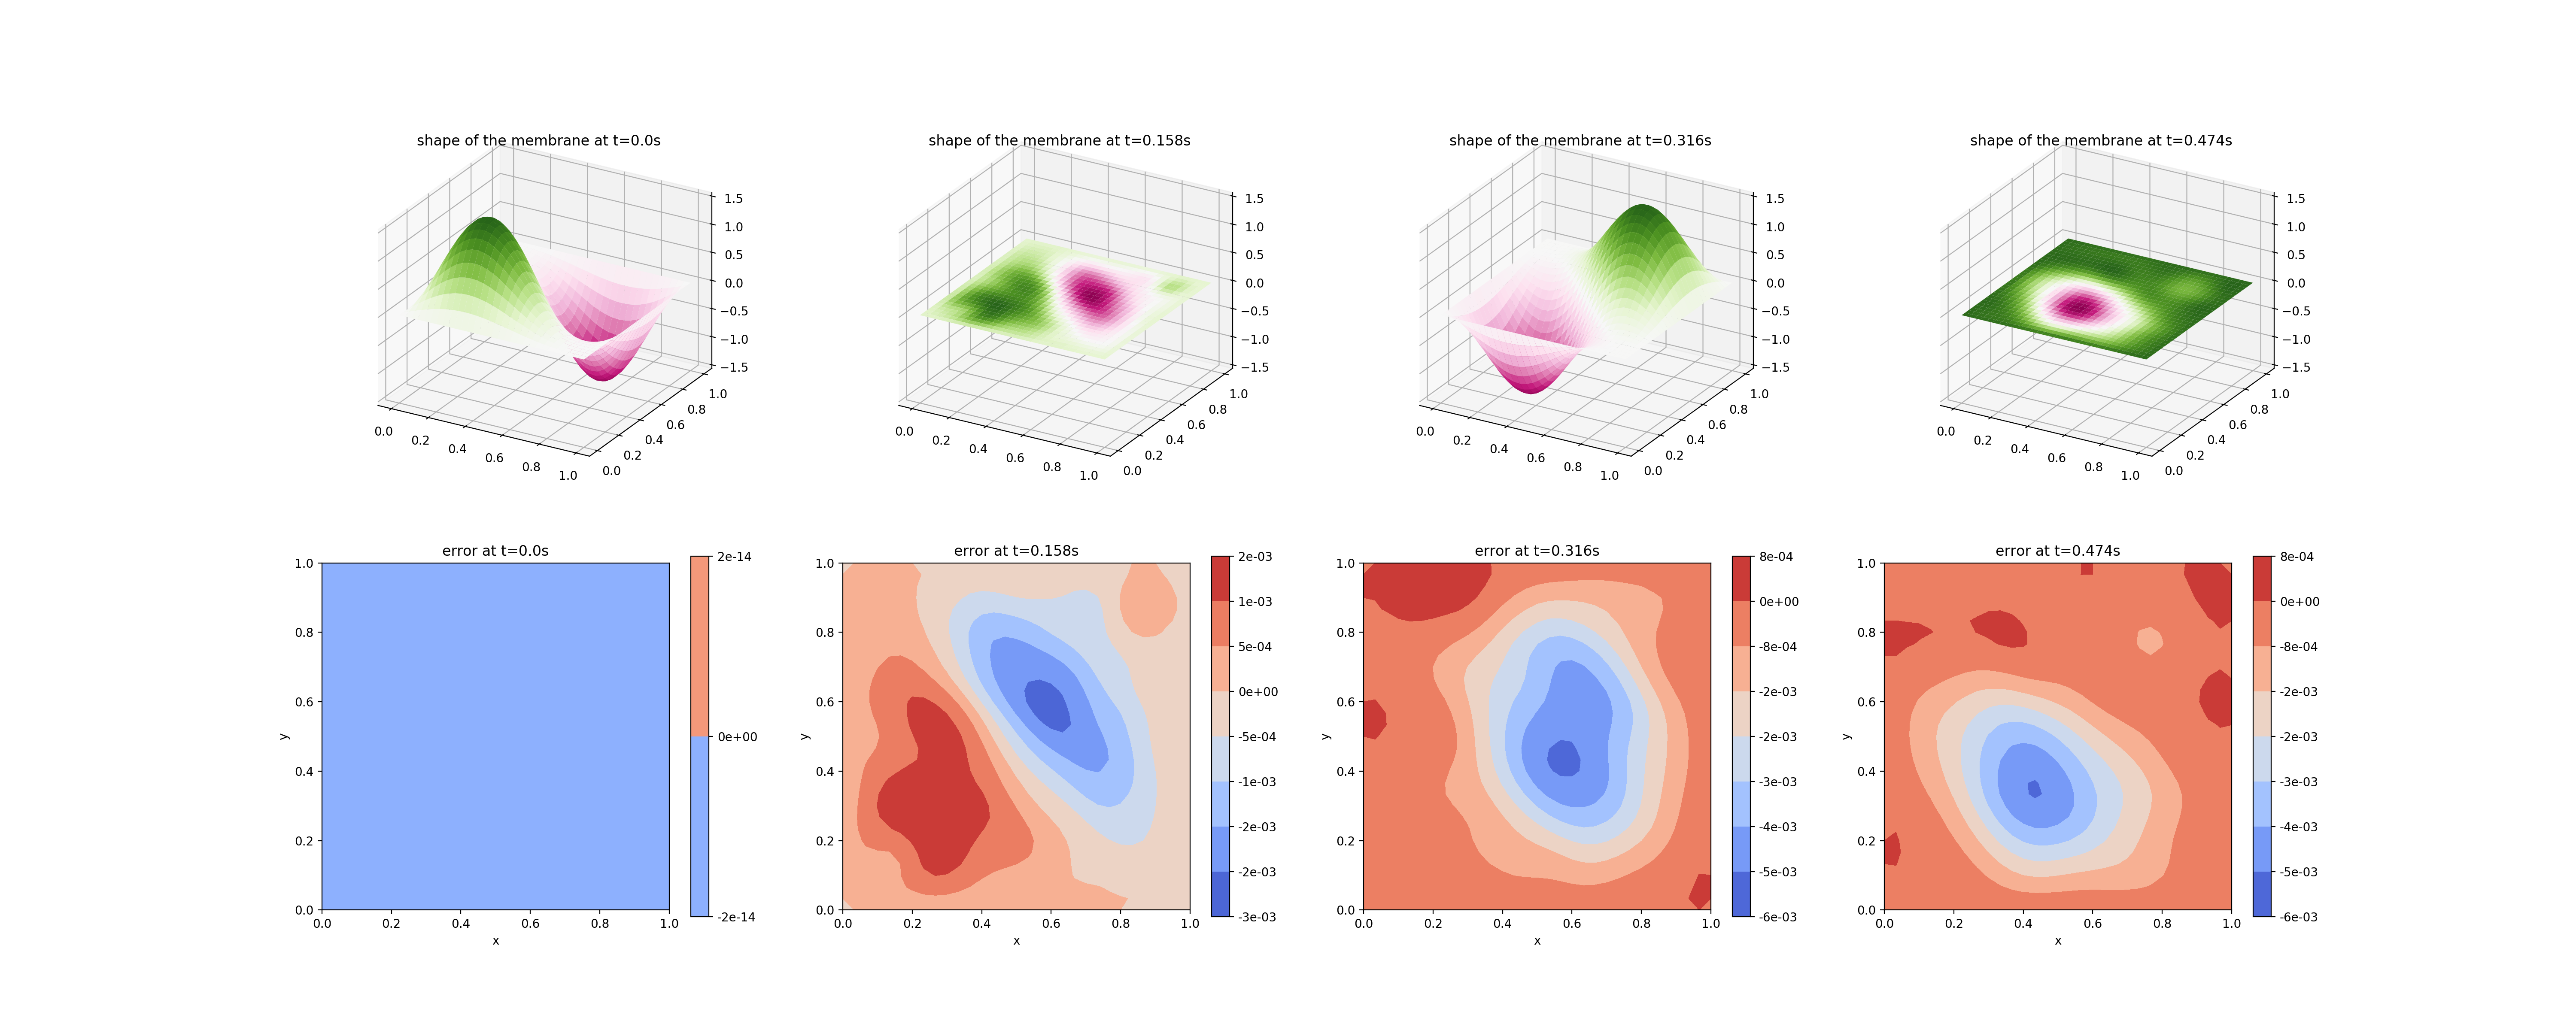

In [14]:
n_grid = 30 # Meshsize

x = torch.linspace(0.0, L_X, n_grid+1)
y = torch.linspace(0.0, L_Y, n_grid+1)
xx, yy = torch.meshgrid(x, y)
xx_np = xx.clone().detach().cpu().numpy()
yy_np = yy.clone().detach().cpu().numpy()

xx = xx.flatten()
yy = yy.flatten()

fig = plt.figure(figsize=(30, 12))
for i in range(4):
    t = T_MAX/4 * i
    tt = torch.ones_like(xx) * t
    uu_np = drum_solution(xx, yy, tt).reshape(n_grid+1, n_grid+1).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+1, projection='3d', proj_type = 'ortho')
    ax.set_zlim(-1.5, 1.5)
    ax.plot_surface(xx_np, yy_np, uu_np, cmap="PiYG") 
    ax.set_title(f'shape of the membrane at t={round(t, 3)}s')
    
    uu_ref = analytical_solution(xx, yy, tt)
    uu_ref_np = uu_ref.detach().cpu().numpy().reshape(n_grid+1, n_grid+1)
    ax = fig.add_subplot(2, 4, i+5)
    err = uu_np-uu_ref_np
    contour = ax.contourf(xx_np, yy_np, err, cmap='coolwarm')
    fig.colorbar(contour, format='%.0e', ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'error at t={round(t, 3)}s')
    
    
plt.show()

In [11]:
fps = 24 # frame per sec
frn = 48 # frame number of the animation

x = torch.linspace(0.0, L_X, n_grid+1)
y = torch.linspace(0.0, L_Y, n_grid+1)
xx, yy = torch.meshgrid(x, y)
uuu = torch.zeros((n_grid+1, n_grid+1, frn))

xx = xx.flatten()
yy = yy.flatten()
for i in range(frn):
    tt = T_MAX/frn * i * torch.ones((n_grid+1)**2)
    uu = drum_solution(xx, yy, tt)
#     uu = analytical_solution(xx, yy, tt)
    uuu[:,:,i] = uu.reshape(n_grid+1, n_grid+1)
xx = xx.reshape(n_grid+1, n_grid+1)
yy = yy.reshape(n_grid+1, n_grid+1)

xx = xx.detach().cpu().numpy()
yy = yy.detach().cpu().numpy()
uuu = uuu.detach().cpu().numpy()

<IPython.core.display.Javascript object>


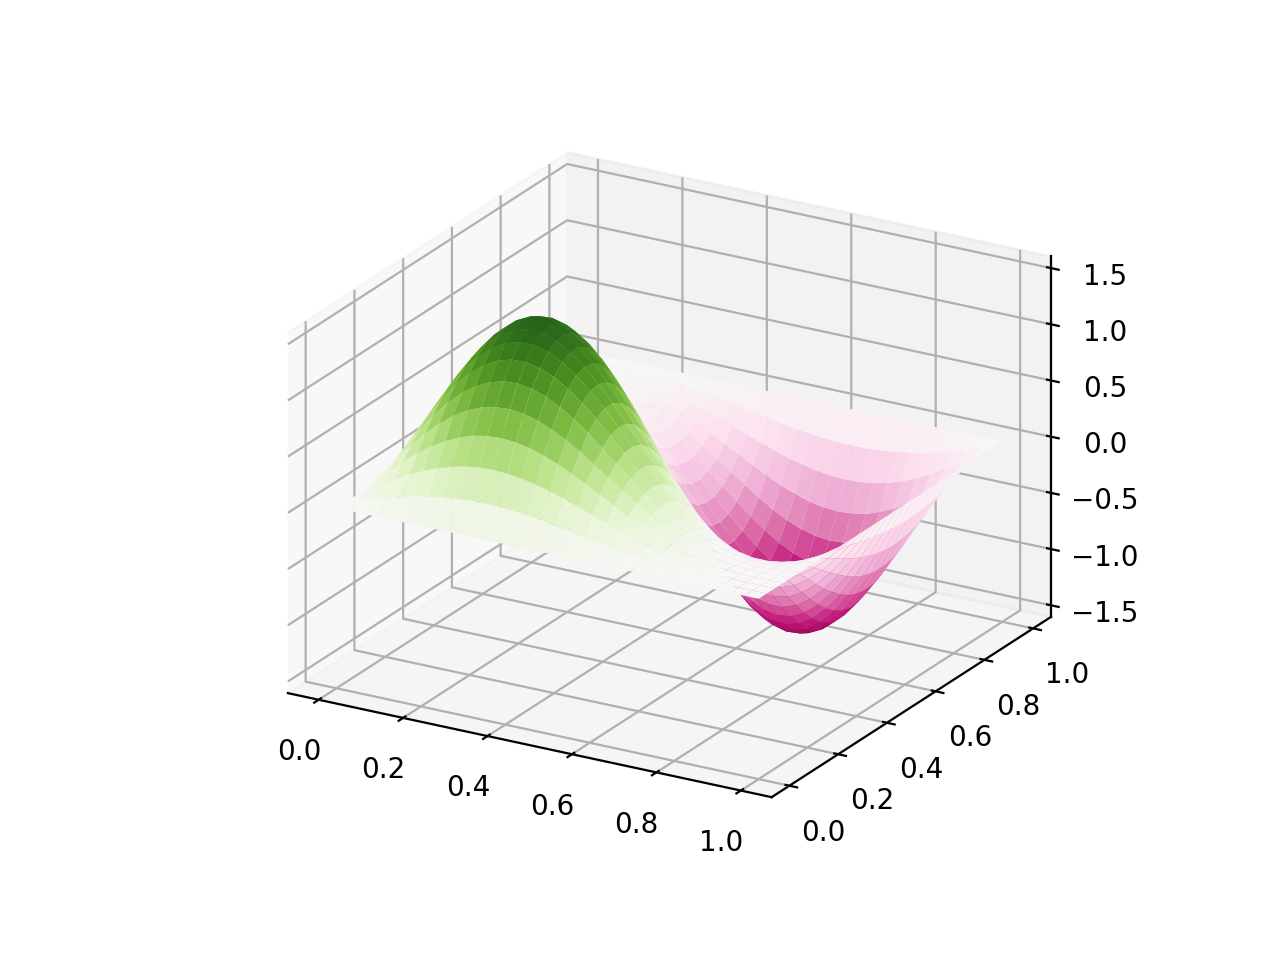

In [12]:
%matplotlib notebook
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(xx, yy, zarray[:,:,frame_number], cmap="PiYG")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')

plot = [ax.plot_surface(xx, yy, uuu[:,:,0], rstride=1, cstride=1, cmap="PiYG")]
ax.set_zlim(uuu.min(), uuu.max())
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(uuu, plot), interval=1000/fps)